In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt

Init Plugin
Init Graph Optimizer
Init Kernel


## Logistic regression correction

Please note that the tensorboard writer has been instanciated in the constructor.

Metal device set to: Apple M1


2021-09-10 17:58:26.375758: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-09-10 17:58:26.375840: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-09-10 17:58:26.488095: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2021-09-10 17:58:26.532280: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-10 17:58:26.532892: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-09-10 17:58:26.532937: I t

Epoch 000	 train loss 0.222228	 train ACC 0.994000	 valid ACC 1.000000
Epoch 001	 train loss 0.076059	 train ACC 0.999000	 valid ACC 1.000000
Epoch 002	 train loss 0.051420	 train ACC 0.999000	 valid ACC 1.000000
Epoch 003	 train loss 0.040295	 train ACC 0.999000	 valid ACC 1.000000
Epoch 004	 train loss 0.033776	 train ACC 0.999000	 valid ACC 1.000000
Epoch 005	 train loss 0.029433	 train ACC 0.999000	 valid ACC 1.000000
Epoch 006	 train loss 0.026306	 train ACC 0.999000	 valid ACC 1.000000
Epoch 007	 train loss 0.023929	 train ACC 0.999000	 valid ACC 1.000000
Epoch 008	 train loss 0.022052	 train ACC 0.999000	 valid ACC 1.000000
Epoch 009	 train loss 0.020527	 train ACC 0.999000	 valid ACC 1.000000
Epoch 010	 train loss 0.019257	 train ACC 0.999000	 valid ACC 1.000000
Epoch 011	 train loss 0.018183	 train ACC 0.999000	 valid ACC 1.000000
Epoch 012	 train loss 0.017260	 train ACC 0.999000	 valid ACC 1.000000
Epoch 013	 train loss 0.016458	 train ACC 0.999000	 valid ACC 1.000000
Epoch 

2021-09-10 17:58:31.848562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


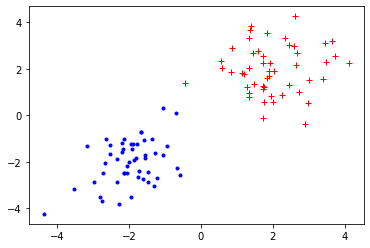

In [2]:
def logistic_regression_dataset():
    # --- Fake dataset ---

    np.random.seed(0)

    ntrain = 1000
    nvalid = 100
    ntest = 100

    mupos = np.array([2., 2.])
    sigmapos = np.array([[1., 0.], [0., 1.]])
    muneg = np.array([-2., -2.])
    sigmaneg = np.array([[.7, .2], [.2, .7]])

    def generate_a_dataset(mupos, sigmapos, muneg, sigmaneg, n):
        npos = int(n/2)
        nneg = n - npos

        Xpos = np.random.multivariate_normal(mupos, sigmapos, npos)
        Ypos = np.stack((np.ones((npos,)), np.zeros((npos,))), axis=1)

        Xneg = np.random.multivariate_normal(muneg, sigmaneg, nneg)
        Yneg = np.stack((np.zeros((nneg,)), np.ones((nneg,))), axis=1)

        X, Y = np.concatenate((Xpos, Xneg)), np.concatenate((Ypos, Yneg))

        idx = np.arange(n)
        np.random.shuffle(idx)
        X, Y = X[idx], Y[idx]

        return np.array(X, dtype='float32'), np.array(Y, dtype='float32')

    Xtrain, Ytrain = generate_a_dataset(
        mupos, sigmapos, muneg, sigmaneg, ntrain)
    Xvalid, Yvalid = generate_a_dataset(
        mupos, sigmapos, muneg, sigmaneg, nvalid)
    Xtest, Ytest = generate_a_dataset(mupos, sigmapos, muneg, sigmaneg, ntest)

    return (Xtrain, Ytrain), (Xvalid, Yvalid), (Xtest, Ytest)


class LogisticRegression(tf.Module):
    def __init__(self, nfeatures, nclasses = 2, name=None):
        super().__init__(name=name)
        # Linear regression parameters
        self.A = tf.Variable(tf.zeros([nfeatures, nclasses]))
        self.b = tf.Variable(tf.zeros([nclasses]))

    def __call__(self,x):
        return tf.nn.softmax(tf.matmul(x, self.A) + self.b)

class LogisticRegressionTrainer:
    
    def __init__(self):
        self._trainloss = tf.losses.CategoricalCrossentropy()
        self._trainlossmetric = tf.metrics.Mean()
        self._trainmetric = tf.metrics.CategoricalAccuracy()
        self._validmetric = tf.metrics.CategoricalAccuracy()
        self._testmetric = tf.metrics.CategoricalAccuracy()

        # tensorboard
        logdir="logs/logisticregression/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
        self.summary_writer = tf.summary.create_file_writer(logdir)
        
    def _loss(self,target,pred):
        return self._trainloss(target, pred)

    @tf.function
    def _train_step(self,x,y):
        with tf.GradientTape() as tape:
            trainpred = self.module(x)
            trainloss = self._loss(y,trainpred)
        grads = tape.gradient(trainloss,self.module.trainable_variables)
        
        self._trainlossmetric.update_state(trainloss)
        self._trainmetric.update_state(y,trainpred)
        
        # Optimizer based on gradient descent
        # We let the optimizer do the gradient descent
        self.optimizer.apply_gradients(zip(grads, self.module.trainable_variables))
        
    @tf.function
    def _valid_step(self,x,y):
        validpred = self.module(x)
        validmetric = self._validmetric.update_state(y,validpred)

    @tf.function
    def _test_step(self,x,y):
        testpred = self.module(x)
        self._testmetric.update_state(y,testpred)

    @staticmethod
    def prepareset(dataset, batchsize):
        dataset = dataset.shuffle(buffer_size=1000)
        dataset = dataset.batch(batchsize)
        return dataset
    
    def train(self, trainset, validset, testset,
            learning_rate = 1e-2, training_epochs = 20,
            batchsize = 10):

        Xtrain, Ytrain = trainset
        Xvalid, Yvalid = validset
        Xtest, Ytest = testset

        # Xtrain (nxtrain,nfeatures)
        nxtrain, self.nfeatures = Xtrain.shape
        nxtest, _ = Xtest.shape
        # Ytrain (nxtrain,nclasses)
        nxtrain, self.nclasses = Ytrain.shape

        
        traindataset = self.prepareset(tf.data.Dataset.from_tensor_slices(
            (Xtrain, Ytrain)), batchsize)
        validdataset = self.prepareset(tf.data.Dataset.from_tensor_slices(
            (Xvalid, Yvalid)), batchsize)
        testdataset = self.prepareset(
            tf.data.Dataset.from_tensor_slices((Xtest, Ytest)), batchsize)

        
        self.module = LogisticRegression(self.nfeatures,self.nclasses)
        self.optimizer = tf.optimizers.SGD(learning_rate=learning_rate)
                
        # We cycle on epochs
        for epoch in range(training_epochs):
            
            self._trainlossmetric.reset_state()
            self._trainmetric.reset_state()
            for Xtrain,Ytrain  in traindataset:
                self._train_step(Xtrain,Ytrain)

            self._validmetric.reset_state()
            for Xvalid,Yvalid  in validdataset:
                self._valid_step(Xvalid,Yvalid)
                
            print("Epoch %03d\t train loss %f\t train ACC %f\t valid ACC %f" %
                      (epoch, self._trainlossmetric.result(),
                       self._trainmetric.result(), self._validmetric.result()))
            
            # tensorboard
            with self.summary_writer.as_default():
                tf.summary.scalar('trainloss', self._trainlossmetric.result(), step=epoch)
                tf.summary.scalar('trainacc', self._trainmetric.result(), step=epoch)
                tf.summary.scalar('validacc', self._validmetric.result(), step=epoch)
            
        self._testmetric.reset_state()
        for Xtest,Ytest  in testdataset:
            self._test_step(Xtest,Ytest)
        print("Test ACC %f"%(self._testmetric.result(),))

        with self.summary_writer.as_default():
            tf.summary.scalar('testacc', self._testmetric.result(), step=training_epochs)
        
        # Found parameters
        print("Estimated A\n", self.module.A.numpy())
        print('Estimated b\n', self.module.b.numpy())
        
        
        Xtest, Ytest = testset
        Ytestpred = self.module(Xtest)
        plt.figure()
        idpos, = np.nonzero(Ytestpred[:, 0] > 0.5)
        idneg, = np.nonzero(Ytestpred[:, 1] > 0.5)
        plt.plot(Xtest[idpos, 0], Xtest[idpos, 1], 'r+')
        plt.plot(Xtest[idneg, 0], Xtest[idneg, 1], 'b.')
        plt.show()

trainer = LogisticRegressionTrainer()
trainer.train(*logistic_regression_dataset())



### Multi Layer Perceptron

The following script generate a _Xor_ dataset that can not be well separated by a logistic regression.

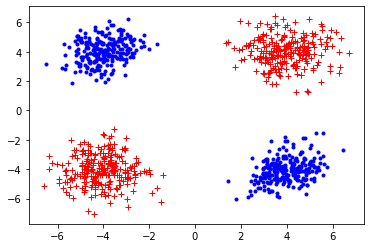

In [3]:
def mlp_dataset():
    # --- Fake dataset ---

    np.random.seed(0)

    ntrain = 1000
    nvalid = 100
    ntest = 100

    mupos = np.array([4., 4.])
    sigmapos = np.array([[1., 0.], [0., 1.]])
    muneg = np.array([4., -4.])
    sigmaneg = np.array([[.7, .2], [.2, .7]])

    def generate_a_dataset(mupos, sigmapos, muneg, sigmaneg, n):
        nelem = int(n/4)
        npos1 = n-nelem*3
        npos2, nneg1, nneg2 = nelem, nelem, nelem

        Xpos1 = np.random.multivariate_normal(mupos, sigmapos, npos1)
        Ypos1 = np.stack((np.ones((npos1,)), np.zeros((npos1,))), axis=1)
        Xpos2 = np.random.multivariate_normal(-mupos, sigmapos, npos2)
        Ypos2 = np.stack((np.ones((npos2,)), np.zeros((npos2,))), axis=1)

        Xneg1 = np.random.multivariate_normal(muneg, sigmaneg, nneg1)
        Yneg1 = np.stack((np.zeros((nneg1,)), np.ones((nneg1,))), axis=1)
        Xneg2 = np.random.multivariate_normal(-muneg, sigmaneg, nneg2)
        Yneg2 = np.stack((np.zeros((nneg2,)), np.ones((nneg2,))), axis=1)

        X = np.concatenate((Xpos1, Xpos2, Xneg1, Xneg2))
        Y = np.concatenate((Ypos1, Ypos2, Yneg1, Yneg2))

        idx = np.arange(n)
        np.random.shuffle(idx)

        X, Y = X[idx], Y[idx]

        return np.array(X, dtype='float32'), np.array(Y, dtype='float32')

    Xtrain, Ytrain = generate_a_dataset(
        mupos, sigmapos, muneg, sigmaneg, ntrain)
    Xvalid, Yvalid = generate_a_dataset(
        mupos, sigmapos, muneg, sigmaneg, nvalid)
    Xtest, Ytest = generate_a_dataset(mupos, sigmapos, muneg, sigmaneg, ntest)

    return (Xtrain, Ytrain), (Xvalid, Yvalid), (Xtest, Ytest)


def plot_dataset(X, Y):
    plt.figure()
    idpos, = np.nonzero(Y[:, 0] == 1.)
    idneg, = np.nonzero(Y[:, 1] == 1.)
    plt.plot(X[idpos, 0], X[idpos, 1], 'r+')
    plt.plot(X[idneg, 0], X[idneg, 1], 'b.')
    plt.show()


def demo(trainset, validset, testset):
    plot_dataset(*trainset)


demo(*mlp_dataset())

### Model

In order to solve this problem you will need to add a second layer to the logistic regression model :

$$h = sigmoid(<x,A_1>+b_1)$$
$$\hat{y} = softmax(<h,A_2>+b_2)$$

where $h \in \mathbb{R}^n$  with $n$ the number of hidden units.

It can still be learnt by the cross-entropy loss:

$$ \mathcal{L}(y,\hat{y}) = -y\log\hat{y} - (1-y)\log(1-\hat{y})$$

In fact, that's a **Multi layer perceptron** !

## Excercice


Write a MLP / MLP Trainer classes

```python
nhiddens = 10
learning_rate = 1e-1
training_epochs = 100
batchsize = 5
```  

Analyze the training trough Tensorboard (it should not work very well though :) )



## Weight initialization and regularization

A good start to speedup the training is to have a better weight initialization than 0 init.

Here is an example to get a variable initialize with a random normal distribution:

```python
self.A1 = tf.Variable(tf.random.normal([nfeatures, nhiddens])))
```

Moreover, weight regularization can prevent the network to be stuck into a local minimum at training start.
Usually a L2 norm is used.

In Tensorflow, you can directly write the standard Tikhonov regularization scheme can expressed by adding a regularization term to the loss:

```python
        def _loss(self,target,pred):
                regularization = tf.nn.l2_loss(self.module.A1) + tf.nn.l2_loss(self.module.A2)
                trainloss = self._trainloss(target, pred)
            return trainloss + self.reg * regularization
```
where `reg` is the regularization weight.

## Exercise

Modify your code to add weight initialization/regularization.
You can use 1e-4 as regularization weight.
